In [97]:
import networkx as nx
import pandas as pd
import matplotlib
from pyvis.network import Network
import community
import numpy as np
import matplotlib.pyplot as plt

# Loading Data

In [190]:
df = pd.read_csv('./hero-network.csv')

# Analysis & cleaning

In [191]:
df.hero1.unique().shape

(6211,)

In [192]:
sum(df.hero1==df.hero2)

2232

In [193]:
df = df[df.hero1!=df.hero2]
df.shape

(572235, 2)

In [194]:
df_nodup = df.drop_duplicates()

In [195]:
df_nodup.shape

(224169, 2)

In [196]:
G1 = nx.from_pandas_edgelist(df_nodup, 'hero1', 'hero2')
deg_centrality = nx.degree_centrality(G1)

In [197]:
heroes_sorted = sorted(deg_centrality, key=deg_centrality.get, reverse=True)
top_heroes = []
for i, hero in enumerate(heroes_sorted):
    if deg_centrality[hero]<0.17: break
    top_heroes.append(hero)
    print(hero,deg_centrality[hero])
    

CAPTAIN AMERICA 0.2966536964980545
SPIDER-MAN/PETER PAR 0.2703501945525292
IRON MAN/TONY STARK  0.23688715953307396
THING/BENJAMIN J. GR 0.2203891050583658
MR. FANTASTIC/REED R 0.21463035019455254
WOLVERINE/LOGAN  0.21338521400778213
HUMAN TORCH/JOHNNY S 0.21182879377431907
SCARLET WITCH/WANDA  0.20622568093385216
THOR/DR. DONALD BLAK 0.20062256809338522
BEAST/HENRY &HANK& P 0.19719844357976654
VISION  0.19315175097276266
INVISIBLE WOMAN/SUE  0.19237354085603114
HAWK 0.18287937743190663


In [198]:
df = df[df.hero1.isin(top_heroes) & df.hero2.isin(top_heroes)]
df.shape

(14604, 2)

In [199]:
pairs = []
for i, x in df.iterrows():
    if not i%10000: print(i)
    sorted_x = x.sort_values(ignore_index=True)
    pairs.append([sorted_x[0], sorted_x[1]])

260000


In [200]:
pairs

[['HAWK', 'IRON MAN/TONY STARK '],
 ['IRON MAN/TONY STARK ', 'SCARLET WITCH/WANDA '],
 ['HAWK', 'SCARLET WITCH/WANDA '],
 ['BEAST/HENRY &HANK& P', 'CAPTAIN AMERICA'],
 ['BEAST/HENRY &HANK& P', 'WOLVERINE/LOGAN '],
 ['BEAST/HENRY &HANK& P', 'VISION '],
 ['BEAST/HENRY &HANK& P', 'MR. FANTASTIC/REED R'],
 ['BEAST/HENRY &HANK& P', 'IRON MAN/TONY STARK '],
 ['BEAST/HENRY &HANK& P', 'SCARLET WITCH/WANDA '],
 ['BEAST/HENRY &HANK& P', 'THING/BENJAMIN J. GR'],
 ['BEAST/HENRY &HANK& P', 'INVISIBLE WOMAN/SUE '],
 ['CAPTAIN AMERICA', 'INVISIBLE WOMAN/SUE '],
 ['INVISIBLE WOMAN/SUE ', 'WOLVERINE/LOGAN '],
 ['INVISIBLE WOMAN/SUE ', 'VISION '],
 ['INVISIBLE WOMAN/SUE ', 'MR. FANTASTIC/REED R'],
 ['INVISIBLE WOMAN/SUE ', 'IRON MAN/TONY STARK '],
 ['INVISIBLE WOMAN/SUE ', 'SCARLET WITCH/WANDA '],
 ['INVISIBLE WOMAN/SUE ', 'THING/BENJAMIN J. GR'],
 ['CAPTAIN AMERICA', 'THING/BENJAMIN J. GR'],
 ['THING/BENJAMIN J. GR', 'WOLVERINE/LOGAN '],
 ['THING/BENJAMIN J. GR', 'VISION '],
 ['MR. FANTASTIC/REED R', '

In [207]:
df_ordered = pd.DataFrame(pairs,columns=["hero1", "hero2"])

In [208]:
df_ordered = df_ordered.assign(hero1_nick = lambda row: row.hero1.str.split("/", expand=True)[0],
              hero2_nick = lambda row: row.hero2.str.split("/", expand=True)[0],
              hero1_name = lambda row: row.hero1.str.split("/", expand=True)[1],
              hero2_name = lambda row: row.hero2.str.split("/", expand=True)[1])
df_ordered = df_ordered.drop(["hero1", "hero2"], axis=1)
df_ordered.fillna("-").head()

,hero1_nick,hero2_nick,hero1_name,hero2_name
0,HAWK,IRON MAN,-,TONY STARK
1,IRON MAN,SCARLET WITCH,TONY STARK,WANDA
2,HAWK,SCARLET WITCH,-,WANDA
3,BEAST,CAPTAIN AMERICA,HENRY &HANK& P,-
4,BEAST,WOLVERINE,HENRY &HANK& P,LOGAN


In [209]:
df_ordered.to_csv("df_ordered.csv")

In [263]:
groups = df_ordered.value_counts(subset=['hero1_nick', 'hero2_nick']).rename("weights").reset_index()
groups.head()

,hero1_nick,hero2_nick,weights
0,HUMAN TORCH,THING,744
1,HUMAN TORCH,MR. FANTASTIC,713
2,MR. FANTASTIC,THING,708
3,INVISIBLE WOMAN,MR. FANTASTIC,701
4,HUMAN TORCH,INVISIBLE WOMAN,694


In [211]:
groups.to_csv("hero-network-weights.csv", index=False)

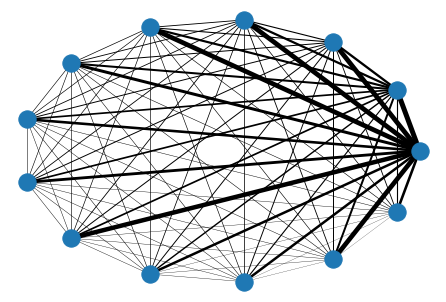

In [258]:
G1 = nx.from_pandas_edgelist(groups, 'hero1_nick', 'hero2_nick', edge_attr=True)
deg_centrality = nx.degree_centrality(G1)
nx.draw_kamada_kawai(G1, width=groups.weights/groups.weights.max()*5)

(-2.0, 2.0)

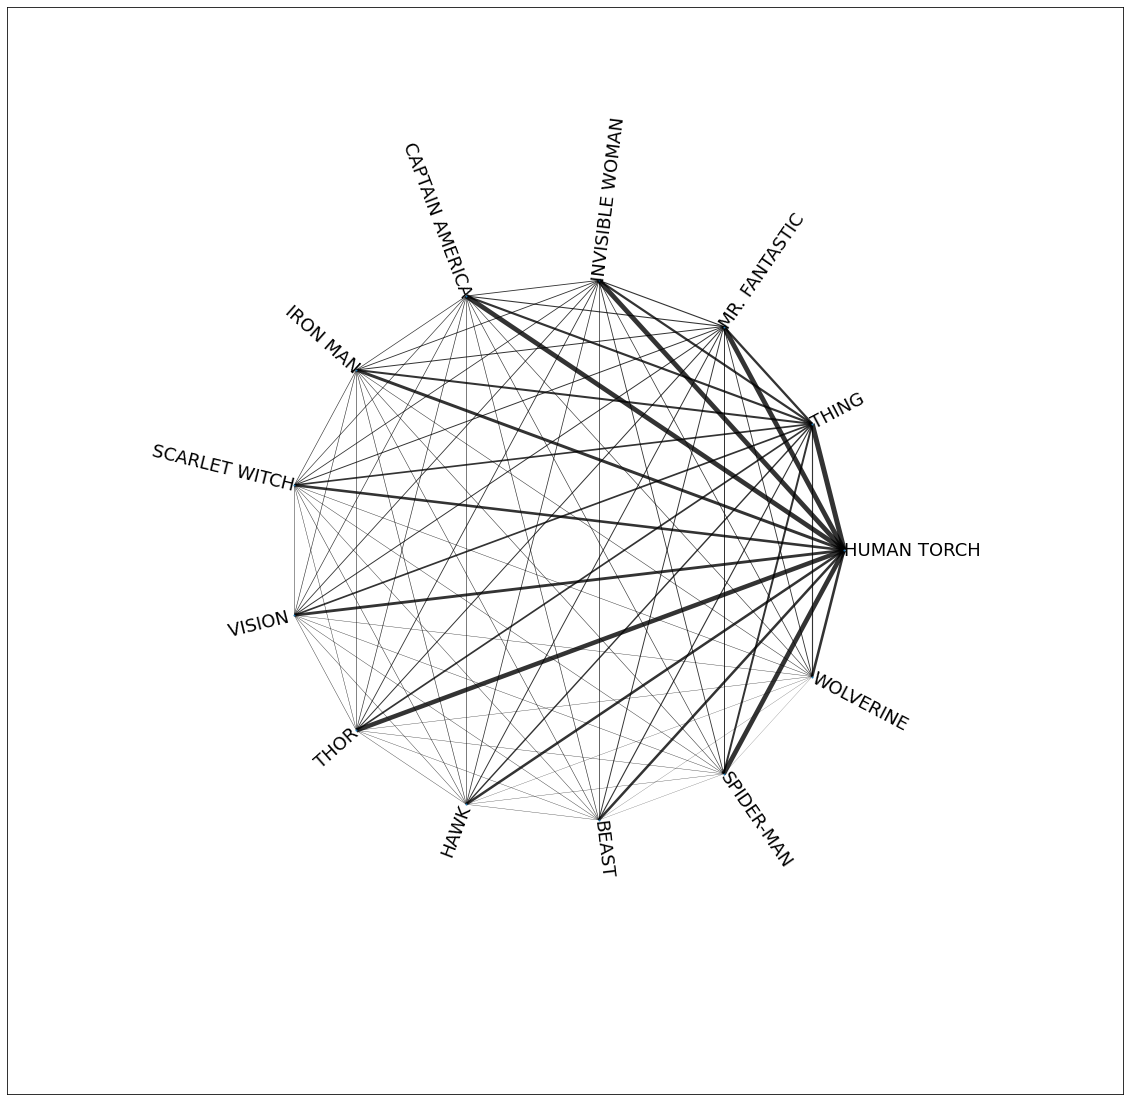

In [259]:
# https://gist.github.com/JamesPHoughton/55be4a6d30fe56ae163ada176c5c7553
G1 = nx.from_pandas_edgelist(groups, 'hero1_nick', 'hero2_nick')
node_locs = nx.circular_layout(G1)
theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in node_locs.items() }


plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G1, pos=node_locs, alpha=1, node_size=1)
labels = nx.draw_networkx_labels(G1, pos=node_locs, font_size=18,horizontalalignment="right")

for key,t in labels.items():
    if 90 < theta[key] or theta[key] < -90 :
        angle = 180 + theta[key]
        t.set_ha('right')
        vect = np.array([0.05, 0.05])
    else:
        angle = theta[key]
        t.set_ha('left')
        vect = np.array([-0.05, -0.05])
#     rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
#     new_pos = np.dot(rot, vect)
#     t.set_position(tuple(np.array(t.get_position()) + new_pos))
    t.set_va('center')
    t.set_rotation(angle)
    t.set_rotation_mode('anchor')

nx.draw_networkx_edges(G1, pos=node_locs, alpha=.8, width=groups.weights/groups.weights.max()*5)
plt.box("off")
plt.xlim(-2,2)
plt.ylim(-2,2)

In [218]:
for key,t in labels.items():
    print(t.get_position())
    pos = t.get_position()
    t.set_position((pos[0]+1, pos[1]+1))
    print(tuple(np.array(t.get_position())))
    break

(2.0, 0.9999999977075137)
(3.0, 1.9999999977075138)


In [260]:
groups.weights

0     744
1     713
2     708
3     701
4     694
     ... 
73     46
74     40
75     33
76     33
77     28
Name: weights, Length: 78, dtype: int64

In [77]:
close_centrality = nx.closeness_centrality(G1)
close_centrality

{'ANGEL': 1.0,
 'ANT-MAN': 1.0,
 'BEAST': 1.0,
 'COLOSSUS II': 1.0,
 'CYCLOPS': 1.0,
 'DAREDEVIL': 1.0,
 'DR. STRANGE': 1.0,
 'HULK': 1.0,
 'HUMAN TORCH': 1.0,
 'INVISIBLE WOMAN': 1.0,
 'IRON MAN': 1.0,
 'MARVEL GIRL': 1.0,
 'MR. FANTASTIC': 1.0,
 'PROFESSOR X': 1.0,
 'SCARLET WITCH': 1.0,
 'SHE-HULK': 1.0,
 'SPIDER-MAN': 1.0,
 'STORM': 1.0,
 'SUB-MARINER': 1.0,
 'THING': 1.0,
 'THOR': 1.0,
 'WASP': 1.0,
 'WOLVERINE': 1.0,
 'WONDER MAN': 1.0}

In [78]:
bet_centrality = nx.betweenness_centrality(G1, normalized=True, endpoints=False)

{'ANGEL': 0.0,
 'ANT-MAN': 0.0,
 'BEAST': 0.0,
 'COLOSSUS II': 0.0,
 'CYCLOPS': 0.0,
 'DAREDEVIL': 0.0,
 'DR. STRANGE': 0.0,
 'HULK': 0.0,
 'HUMAN TORCH': 0.0,
 'INVISIBLE WOMAN': 0.0,
 'IRON MAN': 0.0,
 'MARVEL GIRL': 0.0,
 'MR. FANTASTIC': 0.0,
 'PROFESSOR X': 0.0,
 'SCARLET WITCH': 0.0,
 'SHE-HULK': 0.0,
 'SPIDER-MAN': 0.0,
 'STORM': 0.0,
 'SUB-MARINER': 0.0,
 'THING': 0.0,
 'THOR': 0.0,
 'WASP': 0.0,
 'WOLVERINE': 0.0,
 'WONDER MAN': 0.0}

In [21]:
heroes_sorted = sorted(deg_centrality, key=deg_centrality.get, reverse=True)
for i, hero in enumerate(heroes_sorted):
    print(hero,deg_centrality[hero])
    if i>20: break

CAPTAIN AMERICA 0.29702353124513015
SPIDER-MAN 0.27053140096618356
IRON MAN 0.2371824840268038
THING 0.2206638616175783
MR. FANTASTIC 0.21489792738039581
WOLVERINE 0.2136512388966807
HUMAN TORCH 0.21209287829203677
SCARLET WITCH 0.20648278011531868
THOR 0.20087268193860058
BEAST 0.19744428860838398
VISION  0.1933925510363098
INVISIBLE WOMAN 0.19261337073398785
HAWK 0.18310737104565997
WASP 0.17001714196665108
ANT-MAN 0.16861461742247155
CYCLOPS 0.16845878136200718
ANGEL 0.16721209287829203
STORM 0.16705625681782765
SHE-HULK 0.16690042075736325
DR. STRANGE 0.1662770765155057
HULK 0.16440704378993298
WONDER MAN 0.16097865045971638


In [47]:
n = 10

In [48]:
super_superheros = counts.sort_values(ascending=False)[:n]

In [49]:
super_superheros[:n]

CAPTAIN AMERICA         16259.0
SPIDER-MAN/PETER PAR    13717.0
IRON MAN/TONY STARK     11817.0
THOR/DR. DONALD BLAK    11427.0
THING/BENJAMIN J. GR    10681.0
WOLVERINE/LOGAN         10353.0
HUMAN TORCH/JOHNNY S    10237.0
SCARLET WITCH/WANDA      9911.0
MR. FANTASTIC/REED R     9775.0
VISION                   9696.0
dtype: float64

In [50]:
df_nn = df.loc[df.hero1.isin(super_superheros.index) & df.hero2.isin(super_superheros.index), ]

In [51]:
df_nn

,hero1,hero2
463,IRON MAN/TONY STARK,SCARLET WITCH/WANDA
837,THING/BENJAMIN J. GR,CAPTAIN AMERICA
844,THING/BENJAMIN J. GR,WOLVERINE/LOGAN
847,THING/BENJAMIN J. GR,VISION
855,THING/BENJAMIN J. GR,MR. FANTASTIC/REED R
...,...,...
573393,CAPTAIN AMERICA,THOR/DR. DONALD BLAK
573828,HUMAN TORCH/JOHNNY S,CAPTAIN AMERICA
574357,SPIDER-MAN/PETER PAR,SCARLET WITCH/WANDA
574359,SPIDER-MAN/PETER PAR,CAPTAIN AMERICA


In [83]:
graph_data = df_nn.groupby(['hero1', 'hero2']).size().reset_index(name='weights')

In [84]:
graph_data.head()

,hero1,hero2,weights
0,CAPTAIN AMERICA,HUMAN TORCH/JOHNNY S,88
1,CAPTAIN AMERICA,IRON MAN/TONY STARK,220
2,CAPTAIN AMERICA,MR. FANTASTIC/REED R,82
3,CAPTAIN AMERICA,SCARLET WITCH/WANDA,186
4,CAPTAIN AMERICA,SPIDER-MAN/PETER PAR,79


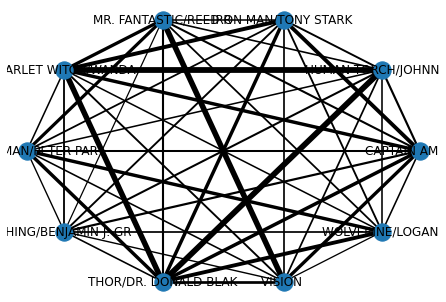

In [116]:
G = nx.from_pandas_edgelist(graph_data, 'hero1', 'hero2', edge_attr=True)
pos = nx.spring_layout(G, k=0.4, iterations=20, scale=0.1)
nx.draw_kamada_kawai(G, with_labels=True, width=graph_data.weights/graph_data.weights.max()*5+1)

In [88]:
G["CAPTAIN AMERICA"]

AtlasView({'HUMAN TORCH/JOHNNY S': {'weights': 70}, 'IRON MAN/TONY STARK ': {'weights': 226}, 'MR. FANTASTIC/REED R': {'weights': 84}, 'SCARLET WITCH/WANDA ': {'weights': 188}, 'SPIDER-MAN/PETER PAR': {'weights': 66}, 'THING/BENJAMIN J. GR': {'weights': 76}, 'THOR/DR. DONALD BLAK': {'weights': 195}, 'VISION ': {'weights': 205}, 'WOLVERINE/LOGAN ': {'weights': 33}})

In [120]:
net = Network(notebook=True)
net.from_nx(G)
net.show("example.html")